In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import re
import nltk
import string
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import torch
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import trange, tqdm
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import xgboost as xgb
from gensim import utils
import gensim.parsing.preprocessing as gsp
from gensim.models import Word2Vec

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
%matplotlib inline

In [2]:
nltk.download('stopwords')
stop = stopwords.words('english')
tknzr = TweetTokenizer()

[nltk_data] Downloading package stopwords to /home/iebi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Glove

In [3]:
# %%time
# embeddings_dict = {}
# with open('./data/glove.6B.300d.txt', 'r', encoding="utf-8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_dict[word] = vector
# print('Found %s word vectors.' % len(embeddings_dict))

In [4]:
# read data
train = pd.read_json('./data/train_gold.json', lines=True, encoding="utf8")
test = pd.read_json('./data/dev_unlabeled.json', lines=True, encoding="utf8")
categories = pd.read_json('./data/categories.json', lines=True, encoding="utf8")

In [5]:
num_categories = train.categories.apply(lambda x: len(x))
num_categories.value_counts() # 這邊我可能會想只取第一類來作，剩下的就亂猜

1    23366
2     5482
3     1678
4      827
5      389
6      258
Name: categories, dtype: int64

<BarContainer object of 6 artists>

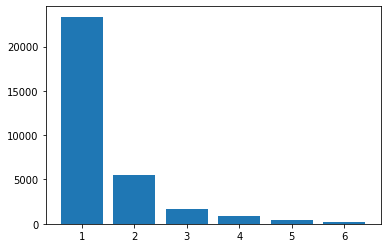

In [6]:
plt.bar(num_categories.value_counts().keys(), num_categories.value_counts().values)

In [7]:
# 只留第一個 (recall rate下降)
# train["categories"] = train["categories"].apply(lambda x: [x[0]])

In [8]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text #  lower+ porter-stemmer
          ]

def clean_text(text):
    text = text.lower()
    text = utils.to_unicode(text)
    for f in filters:
        text = f(text)
    return text

In [9]:
def dataCleansing(df):
    df.text = df.text.apply(clean_text)
    df.reply = df.reply.apply(clean_text)
    df["total_text"] = df.text +' '+ df.reply
    return df

In [10]:
%%time
train = dataCleansing(train)

CPU times: user 3.06 s, sys: 0 ns, total: 3.06 s
Wall time: 3.06 s


In [11]:
%%time
test = dataCleansing(test)

CPU times: user 388 ms, sys: 0 ns, total: 388 ms
Wall time: 387 ms


In [12]:
# num_categories = train.categories.apply(lambda x: len(x))
# num_categories.value_counts() # 這邊我可能會想只取第一類來作，剩下的就亂猜

### 合併text & reply

In [13]:
train["token"] = train.total_text.apply(lambda x: tknzr.tokenize(x))
test["token"] = test.total_text.apply(lambda x: tknzr.tokenize(x))

In [14]:
train

,idx,text,reply,categories,mp4,total_text,token
0,0,agre song niall horan,oui oui,[yes],6dc39e96b11275f064fdaed88273b45e.mp4,agre song niall horan oui oui,"[agre, song, niall, horan, oui, oui]"
1,1,instal scottyfrommarket new track app answer f...,,[no],cfff051f05d8d3b7136c7d58ea6ad55f.mp4,instal scottyfrommarket new track app answer f...,"[instal, scottyfrommarket, new, track, app, an..."
2,2,grow mum nigga despit black tell stop racist s...,join pour hot grit,[smh],bf39e7bd9ad24354ce3ba6822b0104af.mp4,grow mum nigga despit black tell stop racist s...,"[grow, mum, nigga, despit, black, tell, stop, ..."
3,3,rest head chest world feel heavi,😂😂😂😂😂,[wink],173a707a04c277354a2f23cf01d6151e.mp4,rest head chest world feel heavi 😂😂😂😂😂,"[rest, head, chest, world, feel, heavi, 😂, 😂, 😂]"
4,4,imagin hernandez will pull stunt screen block ...,,[yes],aab6d6bfb0c1382269ddba9b71cc8b7a.mp4,imagin hernandez will pull stunt screen block ...,"[imagin, hernandez, will, pull, stunt, screen,..."
...,...,...,...,...,...,...,...
31995,31995,tell duck pull truck hook,,[ok],da53a69a7457bc3076483e9b2f8a5cbc.mp4,tell duck pull truck hook,"[tell, duck, pull, truck, hook]"
31996,31996,like exactli week awai cowboi make round pick ...,,[scared],ea5282d5016838a56a542f3179122715.mp4,like exactli week awai cowboi make round pick ...,"[like, exactli, week, awai, cowboi, make, roun..."
31997,31997,absolut freak night mom’ cancer unemploy monei...,,[hug],14c6869cc1efc58deeeab656fbfcef6d.mp4,absolut freak night mom’ cancer unemploy monei...,"[absolut, freak, night, mom, ’, cancer, unempl..."
31998,31998,receipt life memori weather instil famili coun...,,[hearts],1a4ad489e6398e7398278709c14e1b67.mp4,receipt life memori weather instil famili coun...,"[receipt, life, memori, weather, instil, famil..."


In [15]:
vocab_token = pd.concat([train.token, test.token])

### W2V

In [16]:
%%time
model = Word2Vec(vocab_token, size=300, window=5, min_count=1, iter=20, workers=8)
words = model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 34659
CPU times: user 27.1 s, sys: 207 ms, total: 27.3 s
Wall time: 10.3 s


### TF-idf

In [17]:
# vectorizer = TfidfVectorizer() # using default parameters
# vectorizer.fit(train['total_text'])
# train_X = vectorizer.transform(train['total_text'])
# test_X = vectorizer.transform(test['total_text'])

# train_X.shape, test_X.shape

In [18]:
def sentenceToVec(df):
    data = []
    for sentence in df.token:
        sentence_vector = np.zeros(300)
        count = 0

        for word in sentence:
            # Glove
    #         embedding_vector = embeddings_dict.get(word)
            # Word2Vec
            try:
                sentence_vector += np.array(model.wv.get_vector(word))
                count += 1
            except:
                pass

        if count == 0:
            data.append(sentence_vector)
        else:
            data.append(sentence_vector / count)

    return np.array(data)

In [19]:
label_dict = {}
for i, col in enumerate(categories.iloc[0]):
    label_dict[col] = i

In [20]:
def label_to_onehot(labels):
    onehot = np.zeros(len(label_dict))
    for l in labels:
        onehot[label_dict[l]] = 1
    return onehot


def label_to_all(datasets):
    label = []
    for row in datasets["categories"]:
        label.append(label_to_onehot(row))
    return np.array(label)

In [21]:
data = sentenceToVec(train)

In [22]:
labels = label_to_all(train)

In [23]:
data.shape

(32000, 300)

In [24]:
labels.shape

(32000, 43)

In [25]:
### 將訓練資料分為訓練組及驗證組
# X_train, X_test, y_train, y_test = train_test_split(train_X, labels, test_size=0.1, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

In [26]:
X_train, y_train = data, labels

In [27]:
CATEGORIES = list(label_dict.keys())

### test data

In [28]:
X_test = sentenceToVec(test)

In [29]:
X_test.shape

(4000, 300)

# Xgboost

In [30]:
%%time
Predict_results= []
for i in tqdm(range(43)):
    dtrain = xgb.DMatrix(X_train, label=y_train.T[i])
    dtest = xgb.DMatrix(X_test)
    params = {
    'booster': 'gbtree',
    'learning_rate':0.1,
    'n_etimators': 300, # 300
    'max_depth': 10, # 12, 3isbad
    'min_child_weight':5,
    'gamma':0.5,
    'colsample_bytree':0.8,
    'subsample':0.8,
    'reg_alpha':1,
    'reg_lambda':0.1,
    'objective':'binary:logistic',
    'nthread': 8,                 
    }
    bst = xgb.train(params, dtrain)
    pred = bst.predict(dtest)
    Predict_results.append(pred)

/home/iebi/anaconda3/envs/pytorch/lib/python3.6/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



CPU times: user 4min 54s, sys: 4.33 s, total: 4min 58s
Wall time: 59.3 s


In [31]:
Predict_results = np.array(Predict_results).T

In [32]:
Predict_res = []
for row in Predict_results:
    tmp = np.zeros(43)
    tmp[row.argsort()[-6:]] = 1
    Predict_res.append(tmp)

In [33]:
Predict_res = np.array(Predict_res).astype(np.uint8)

In [34]:
def evaluation(y_pred, y_test):
    rate = []
    for i, row in enumerate(y_test):
        rating = 0
        for j, ans in enumerate(row):
            if ans == 1 and y_pred[i][j] == 1:
                rating += 1
        rate.append(rating/y_test[i].sum())
        acc = np.array(rate).sum() / len(y_pred)
    return acc

In [35]:
# evaluation(Predict_res, y_test)

##############

In [36]:
test = pd.read_json('./data/dev_unlabeled.json', lines=True, encoding="utf8")

In [37]:
Predict_res.shape

(4000, 43)

In [38]:
test

,idx,text,reply
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!
2,32002,I know GTC festival not happening next month b...,
3,32003,"Lordy, my daughter just said, “I wonder how th...",
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...
...,...,...,...
3995,35995,WHY TF DO LOCALS LIKE USING GIFS SO MUCH THEYR...,
3996,35996,Choose a gif that best describes the Republica...,
3997,35997,fuck soon,When soon
3998,35998,SOMEBODY GIVE ME A HUG PLEASE \n\nI would real...,I hope you’re doing okay or will be okay!! Sen...


In [39]:
def submit_json(df, results):
    cat_results = []
    for row in results:
        tmp = []
        for i, res in enumerate(row):
            if res == 1:
                tmp.append(CATEGORIES[i])
        cat_results.append(tmp)
    df["categories"] = cat_results
    df = df[['idx', 'categories', 'reply', 'text']]
    return df

In [40]:
results_df = submit_json(test, Predict_res)

In [41]:
results_df.to_json('dev.json', orient='records', lines=True)

In [42]:
results_df

,idx,categories,reply,text
0,32000,"[applause, dance, good_luck, happy_dance, plea...",$tyratomaro #BailoutHumans,"Drop your cash app, use hashtag #BailoutHumansNow"
1,32001,"[agree, applause, happy_dance, sigh, slow_clap...",CONGRATS!!!!!,After interviewing with a few incredible peopl...
2,32002,"[applause, facepalm, no, omg, smh, yes]",,I know GTC festival not happening next month b...
3,32003,"[agree, applause, facepalm, oh_snap, omg, yes]",,"Lordy, my daughter just said, “I wonder how th..."
4,32004,"[agree, applause, facepalm, idk, seriously, yes]",Watching everyone else get their weekly unempl...,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK
...,...,...,...,...
3995,35995,"[agree, applause, facepalm, sigh, slow_clap, yes]",,WHY TF DO LOCALS LIKE USING GIFS SO MUCH THEYR...
3996,35996,"[eww, facepalm, scared, seriously, smh, thumbs...",,Choose a gif that best describes the Republica...
3997,35997,"[agree, applause, hug, shocked, yes, you_got_t...",When soon,fuck soon
3998,35998,"[agree, awww, hearts, hug, please, you_got_this]",I hope you’re doing okay or will be okay!! Sen...,SOMEBODY GIVE ME A HUG PLEASE \n\nI would real...
